<a href="https://colab.research.google.com/github/ppunktw/Bayesian_CNN_Brain_Tumor_Classification/blob/master/Bayesian_CNN_Brain_Tumor_Classification_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A project by Pascal Weber, M.Sc. and Paul Windisch, MD.

In collaboration with the European CyberKnife Center in Munich.

*Due to privacy reasons, no images from the cyberknife dataset (vestibular schwannoma) can be shown in this notebook*

Based on Daniel Huynh's tutorial on Bayesian deep learning with fast.ai: https://github.com/DanyWind/fastai_bayesian

# Imports & custom functions/classes

In [0]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from fastai.basic_train import DatasetType
from fastai.torch_core import to_np
from typing import Callable
from fastai.callbacks.oversampling import OverSamplingCallback
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, confusion_matrix

In [0]:
class CustomDropout(nn.Module):

    """Custom Dropout module to be used as a baseline for MC Dropout"""

    def __init__(self, p:float, activate=True):
        super().__init__()
        self.activate = activate
        self.p = p
    def forward(self, x):
        return nn.functional.dropout(x, self.p, training=self.training or self.activate)
    def extra_repr(self):
        return f"p={self.p}, activate={self.activate}"

def switch_custom_dropout(m, activate:bool=True, verbose:bool=False):

    """Turn all Custom Dropouts training mode to true or false according to the variable activate"""

    for c in m.children():
        if isinstance(c, CustomDropout):
            print(f"Current active : {c.activate}")
            print(f"Switching to : {activate}")
            c.activate = activate
        else:
            switch_custom_dropout(c, activate=activate)

def convert_layers(model:nn.Module, original:nn.Module, replacement:nn.Module,
                   get_args:Callable=None, additional_args:dict={}):
  
    """Convert modules of type "original" to "replacement" inside the model
    get_args : a function to use on the original module to eventually get its arguements to pass to the new module
    additional_args : a dictionary to add more args to the new module"""

    for child_name, child in model.named_children():
        if isinstance(child, original):
            # First we grab args from the child
            if get_args:
                original_args = get_args(child)
            else:
                original_args = {}

            # If we want to provide additional args
            if additional_args:
                args = {**original_args, **additional_args}
            else:
                args = original_args
            
            new_layer = replacement(**args)
            setattr(model, child_name, new_layer)
        else:
            convert_layers(child, original, replacement,
                           get_args, additional_args)

# Load Data / Connect to Google Drive

## Load Data without Transformation

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
project_dir = "/gdrive/My Drive/..."

train_dir = project_dir + '/.../train/'
val_dir = project_dir + '/.../valid/'
#test_dir = project_dir + '/.../test/' # Test set is optional

print(train_dir)
%cd {project_dir}

In [0]:
data = ImageDataBunch.from_folder(project_dir, train="train", valid="valid", size=224, bs=32)
# If using a pretrained model based on imagenet data, normalize it using its stats
data.normalize(imagenet_stats)
#data.normalize()

## Load Data with Transformation

In [0]:
# Define the transformer
tfms = get_transforms(flip_vert=True, max_rotate=90, max_lighting=0.2, max_zoom=1.2, max_warp=0.)

In [0]:
data = (ImageList.from_folder(project_dir)
        .split_by_folder(valid="valid")
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=32))
data.normalize(imagenet_stats)

# Create & train the model

## Use a pretrained model

**OverSamplingCallback** takes care of imbalances in your data. More info here: https://github.com/fastai/fastai/blob/e4cdac14bb45685623cd3546de8bd2c33728a90d/fastai/callbacks/oversampling.py

**mixup** is a technique for data augmentation. It mixes up two different images for training purposes. More info here: https://docs.fast.ai/callbacks.mixup.html

In [0]:
# ps sets the dropout percentage
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=[OverSamplingCallback], ps=0.5).mixup()

fast.ai automatically cuts the last block of the pretrained model and adds the necessary layers on top (and adjusts the dense layer according to your data). If you want to customize the model, check here: https://forums.fast.ai/t/how-change-layers-pre-trained-model-wihout-using-learner/46578

In [0]:
# function to find the optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

In [0]:
learn.save("resnet50-stage-1")

In [0]:
learn.recorder.plot_losses()

## Unfreezing, fine-tuning, learning rates

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# Unfreezing opens up all the layers of the model (also those of the pretrained) for training
learn.unfreeze()
# for the lower layers, choose a learning rate that is ~10x lower than where the loss starts increasing
# for the top layers, choose lr/5 or lr/10
learn.fit_one_cycle(4, slice(1e-5, lr/5))

In [0]:
learn.save("resnet50-stage-2")

## Changing the data and train again with the same learner

E.g. change the size of the images or add some augmentation.

In [0]:
# data = new_data
learn.data = data

In [0]:
learn.freeze() # Freeze again to only train the last few layers

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2/2
learn.fit_one_cycle(5, slice(lr))

In [0]:
learn.save("resnet50-stage-1-new-data")

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5)) 

In [0]:
learn.save("resnet50-stage-2-new-data")

## Loading a model

In [0]:
learn = cnn_learner(data, models.resnet50,  metrics=error_rate, callback_fns=[OverSamplingCallback], ps=0.5).load("saved-model")

## Interpretation - GradCam

In [0]:
# GradCam implementation by: https://github.com/anhquan0412/animation-classification/blob/master/gradcam.py
# Download this file and import

import sys
sys.path.append('/gdrive/My Drive/Propulsion-Project')
from gradcam import *

In [0]:
interp = ClassificationInterpretation.from_learner(learn, ds_type = DatasetType.Valid)

In [0]:
interp.plot_top_losses(4, heatmap=True, heatmap_thresh=40, figsize=(10,10))

In [0]:
interp.most_confused(min_val=2)

In [0]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [0]:
gcam = GradCam.from_interp(learn, interp, 2) #image_idx from ds.valid_ds or ds.test_ds
gcam.plot(plot_gbp=False)

# Predicting

## Convert the model to Bayesian
Keeping dropouts activated while predicting

In [0]:
# Convert nn.Dropout to CustomDropout module
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)

# Turn on the stochasticity, I use verbose just to make sure it's working fine
switch_custom_dropout(learn.model,True,verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True


## Functions

In [0]:
def get_prediction_probabilites(learner, img, n_times=50):

  """Get the prediction probabilites for an image for n samples"""
  pred = learner.predict_with_mc_dropout(img, n_times=n_times)
  probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
  probs = torch.cat(probs)
  return probs

In [0]:
def get_counts_and_entropy(learner, img, n_times=50, base=2):

    """Returns entropy and the predicted categories of an image for n samples"""
    
    probs = get_prediction_probabilites(learner, img, n_times)
    labels = [np.argmax(p) for p in to_np(probs)]
    counts_d = dict()
    for i in [data.classes[label] for label in labels]:
      counts_d[i] = counts_d.get(i, 0) + 1
    value,counts = np.unique(labels, return_counts=True)
    return counts_d, entropy(counts, base=base)
    
def plot_img_with_entropy(learner,img, n_times=50):
    fig = plt.figure(figsize=(4,4), dpi=120)
    counts, e = get_counts_and_entropy(learner, img, n_times)
    img = to_np(img.data.permute(1,2,0))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout
    plt.title("Entropy : {:.2f}\n Predictions: {}".format(e, counts))

In [0]:
def get_predictions_with_threshold(learner, img, n_times=50, threshold_=0.7):
  
  """Gets the the predicted class probabilites for the n samples.
  If the mean probability is higher than the threshold, make a prediction.
  Else return the mean probability of the most likely category."""

  probs = get_prediction_probabilites(learner, img, n_times)
  mean_probs = probs.mean(dim=0)[0]
  if mean_probs.max() > threshold_:
    return ("Predicted category: {}\n\n Mean probability: {:.2f}".format(data.classes[np.argmax(mean_probs)], mean_probs.max()))
  else:
    return ("No clear category\n\n Mean probability for most likely category: {:.2f}".format(mean_probs.max()))

def plot_img_with_prediction(learner, img, n_times=50, threshold_=0.7):
    fig = plt.figure(figsize=(4,4), dpi=120)
    p = get_predictions_with_threshold(learner, img, n_times, threshold_)
    img = to_np(img.data.permute(1,2,0))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout
    plt.title(p)

def plot_pred_hist(learner, img, n_times=100, n_bins=20, figsize=(10, 3)):

    """Plots the histogram of the predicted probabilites for n samples"""
    
    probs = get_prediction_probabilites(learn, img, n_times=n_times)

    fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=120)
    for i in range(3):
        sns.distplot(probs[:, :, i], ax=ax[i], kde=False, bins=n_bins, hist_kws={'range':(0,1), "edgecolor":"k", "linewidth":1})
        ax[i].set_xlim([-.1, 1.1])
        ax[i].set_ylim([0, n_times])
        ax[i].title.set_text("{} (mean prob: {:.2f})".format(data.classes[i], probs[:, :, i].mean()))
    plt.tight_layout()
    plt.show()

In [0]:
def get_preds_sample(learn, ds_type=DatasetType.Valid, n_sample=10, reduce=None,activ=None,with_loss=False):

    """Get the mean of the MC Dropout predictions from a learner"""
    
    preds = []
    for i in range(n_sample):
        pred, y = learn.get_preds(ds_type=ds_type,activ=activ)
        pred = pred.view((1,) + pred.shape)
        preds.append(pred)
    preds = torch.cat(preds)
    if reduce == "mean":
        preds = preds.mean(dim=0)
    return preds, y

## Predicting Entropy & Class Probability

Images that are known by the model should have a lower entropy than images that the model has never seen. The lower the entropy, the lower the uncertainty

#### Brain Image from the Test Set

In [0]:
plot_img_with_entropy(learn, data.valid_ds.x[280], n_times=50)

In [0]:
plot_img_with_prediction(learn, data.valid_ds.x[280], n_times=50)

In [0]:
gcam = GradCam.from_one_img(learn, data.valid_ds.x[280])
gcam.plot(plot_gbp=False)

In this case, the model is more focused on the left ear than on the tumor itself. The VS data we use to train the model were all cases with prior operation. So it might be that the model notices that the two ear regions look different (operated vs. non operated)

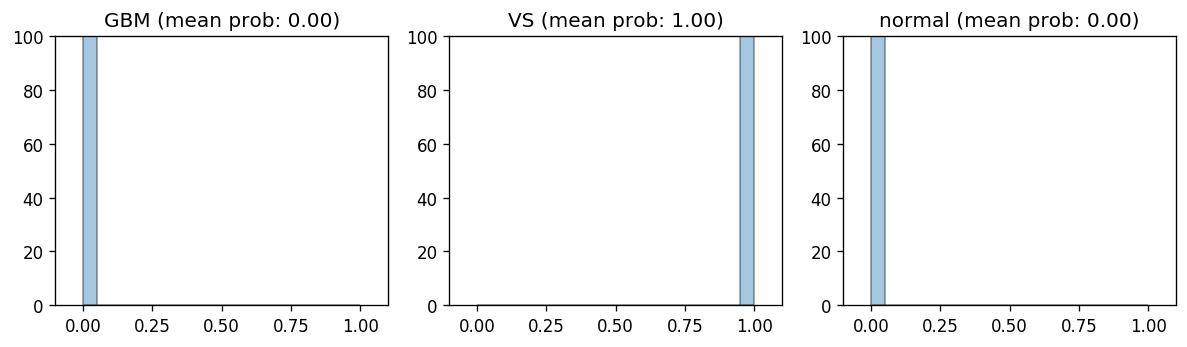

In [0]:
plot_pred_hist(learn, data.valid_ds.x[280], 100)

#### Brain Image from the Internet

In [0]:
!wget https://img.medscape.com/news/2015/rp_150507_glioblastoma_demyelination_800x600.jpg

In [0]:
brain_gbm = open_image("rp_150507_glioblastoma_demyelination_800x600.jpg")

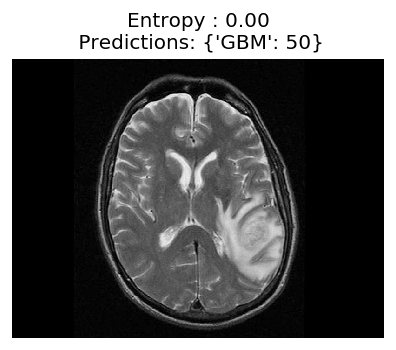

In [0]:
plot_img_with_entropy(learn, brain_gbm, n_times=50)

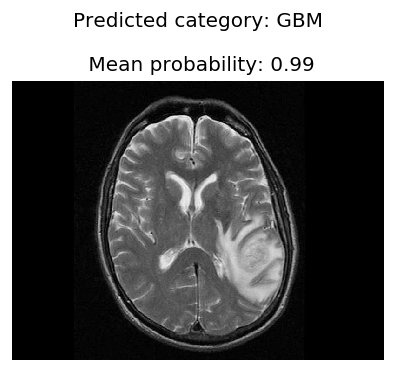

In [0]:
plot_img_with_prediction(learn, brain_gbm, n_times=50)

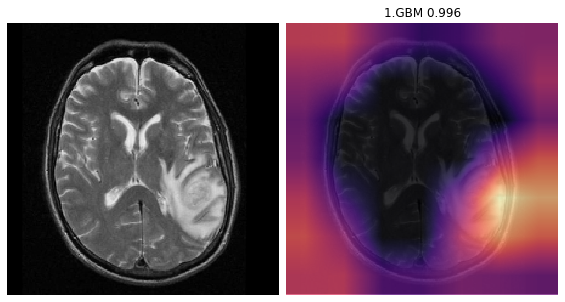

In [0]:
gcam = GradCam.from_one_img(learn,brain_gbm)
gcam.plot(plot_gbp=False)

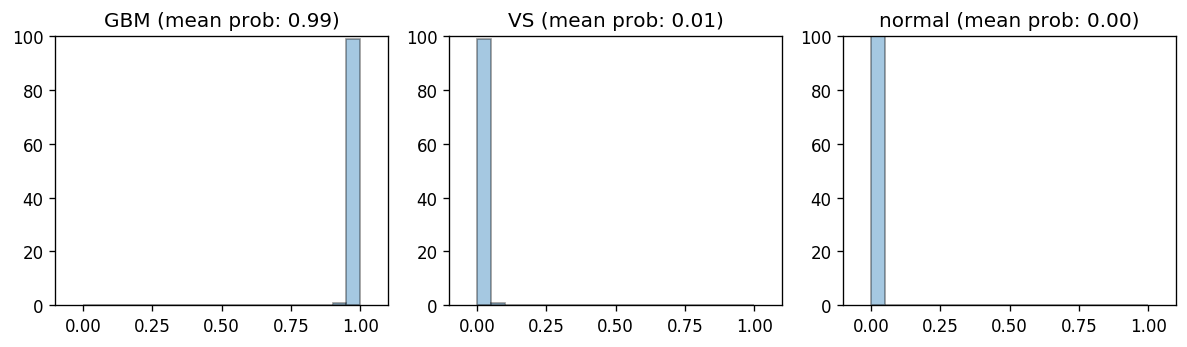

In [0]:
plot_pred_hist(learn, brain_gbm, 100)

In [0]:
!wget https://healthcare-in-europe.com/media/story_section_text/10349/image-01-glioblastoma-multiforme-mrt-t1km-cor_hires.jpg

In [0]:
brain_gbm2 = open_image("image-01-glioblastoma-multiforme-mrt-t1km-cor_hires.jpg")

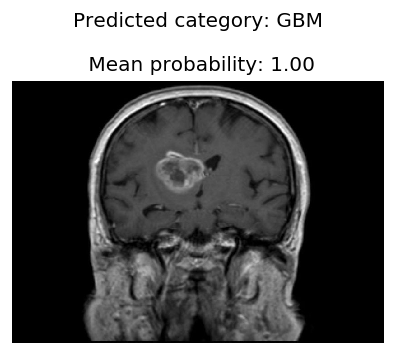

In [0]:
plot_img_with_prediction(learn, brain_gbm2, n_times=50)

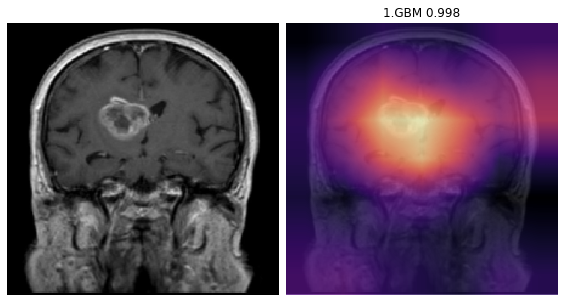

In [0]:
gcam = GradCam.from_one_img(learn,brain_gbm2)
gcam.plot(plot_gbp=False)

In [0]:
!wget http://www.bimjonline.com/Imageoftheweek/Image27.08.2012/VS1.jpg

In [0]:
brain_vs = open_image("VS1.jpg")

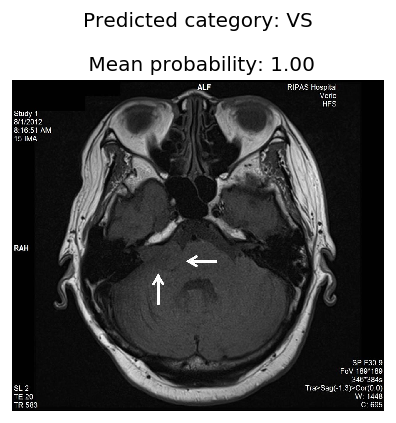

In [0]:
plot_img_with_prediction(learn, brain_vs, n_times=50)

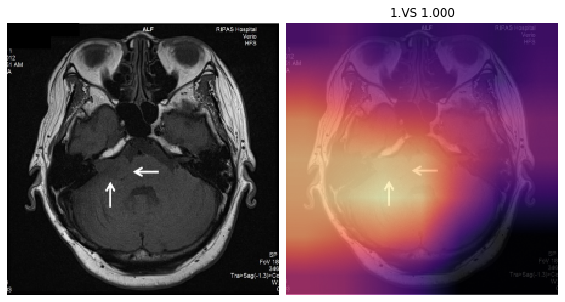

In [0]:
gcam = GradCam.from_one_img(learn,brain_vs)
gcam.plot(plot_gbp=False)

In [0]:
!wget https://www.diagnosticimaging.com/sites/default/files/Fig%201_4.jpg

In [0]:
brain_vs2 = open_image("Fig 1_4.jpg")

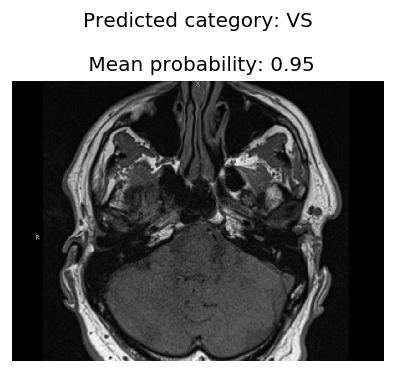

In [0]:
plot_img_with_prediction(learn, brain_vs2, n_times=50)

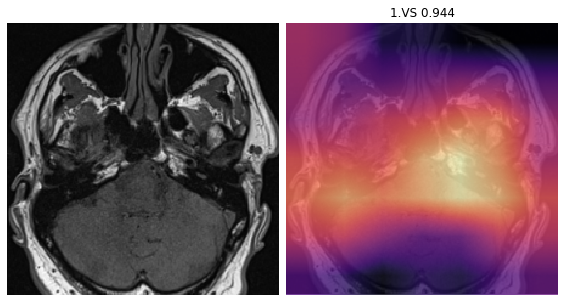

In [0]:
gcam = GradCam.from_one_img(learn, brain_vs2)
gcam.plot(plot_gbp=False)

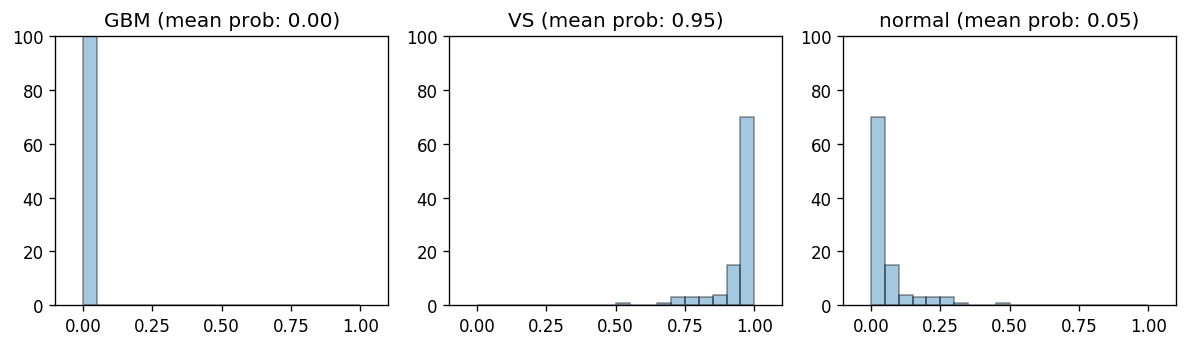

In [0]:
plot_pred_hist(learn, brain_vs2, 100)

### Example with high uncertainty

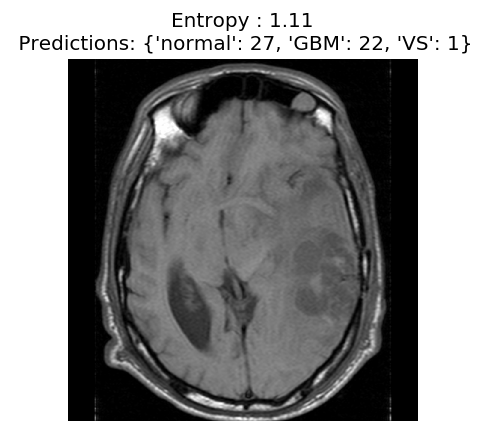

In [0]:
plot_img_with_entropy(learn, data.valid_ds.x[38], n_times=100)

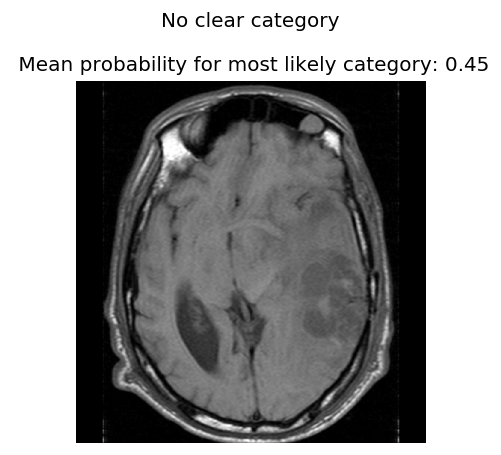

In [0]:
plot_img_with_prediction(learn, data.valid_ds.x[38], n_times=100)

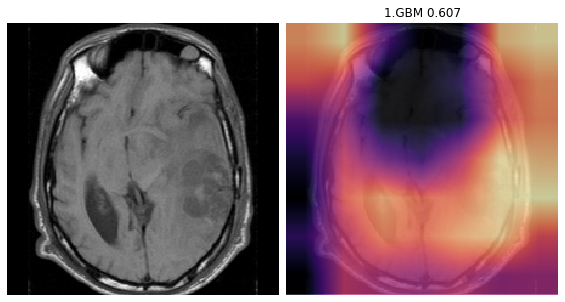

In [0]:
gcam = GradCam.from_interp(learn, interp, 38)
gcam.plot(plot_gbp=False)

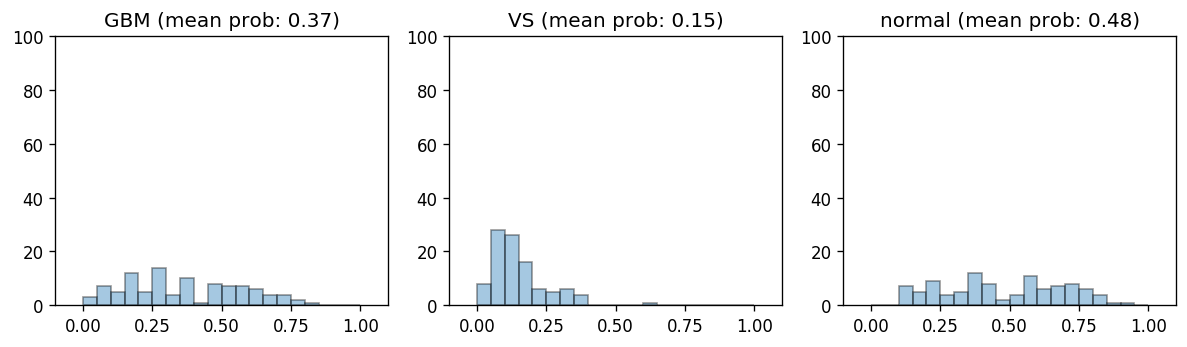

In [0]:
plot_pred_hist(learn, data.valid_ds.x[38], 100)

## Overall accuracy of the model & Confusion Matrix

In [0]:
# Loading the model
learn = cnn_learner(data, models.resnet50, metrics=error_rate, callback_fns=[OverSamplingCallback], ps=0.5).load("3-classes-resnet50-stage2-version3")

# Predicting on the dataset
y_preds, y_true = get_preds_sample(learn, ds_type=DatasetType.Valid, n_sample=100) # Gets y_preds based on the VALIDATION dataset

In [0]:
# Saving & loading the predictions
import pickle

SAVE = False
LOAD = True

if SAVE:
  with open("100predictions_ypred.pickle", "wb") as filename:
    pickle.dump(y_preds, filename)
  with open("100predictions_ytrue.pickle", "wb") as filename:
    pickle.dump(y_true, filename)

if LOAD:
  with open('100predictions_ypred.pickle', 'rb') as filename:
    y_preds = pickle.load(filename)
  with open('100predictions_ytrue.pickle', 'rb') as filename:
    y_true = pickle.load(filename)

In [0]:
def plot_nice_confusion_mtx(confusion_matrix):
  cmtx = np.array(confusion_matrix)

  fig = plt.figure(figsize=(5,5), dpi=120)
  plt.imshow(cmtx, interpolation='nearest', cmap="Blues")
  plt.title("Confusion matrix\n 100 samples, mean probability > 90%")
  tick_marks = np.arange(data.c)
  plt.xticks(tick_marks, data.classes, rotation=90)
  plt.yticks(tick_marks, data.classes, rotation=0)

  thresh = cmtx.max() / 2.
  for i, j in itertools.product(range(cmtx.shape[0]), range(cmtx.shape[1])):
      coeff = f'{cmtx[i, j]}'
      plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cmtx[i, j] > thresh else "black")

  ax = fig.gca()
  ax.set_ylim(3-.5,-.5)
                      
  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.grid(False)

def print_confusion_and_accuracy(y_true, y_preds, threshold_=False):
  
  """Gets the confusion matrix and the accuracy of the model.
  With or without threshold."""

  index=["true:GBM", 'true:VS', 'true:normal']
  columns=["pred:GBM", 'pred:VS', 'pred:normal']
  y_pred_mean = to_np(y_preds).mean(axis=0)
  if threshold_:
    y_pred_thres = []
    y_true_thres = []
    not_classified = 0
    for i, pred in enumerate(y_pred_mean):
      if any(pred > threshold_):
        y_pred_thres.append(np.argmax(pred))
        y_true_thres.append(y_true[i])
      else:
        not_classified += 1
    cmtx = pd.DataFrame(confusion_matrix(y_true_thres, y_pred_thres), index, columns)
    acc = accuracy_score(y_true_thres, y_pred_thres)
    print("No prediction in {} cases".format(not_classified))
    print("--------------")
  else:
    cmtx = pd.DataFrame(confusion_matrix(y_true, np.argmax(y_pred_mean, axis=1)), index, columns)
    acc = accuracy_score(y_true, np.argmax(y_pred_mean, axis=1))
  print(cmtx)
  print("--------------")
  print(acc)

In [0]:
print_confusion_and_accuracy(y_true, y_preds, threshold_=False)

             pred:GBM  pred:VS  pred:normal
true:GBM           64       18            5
true:VS             1       90            0
true:normal         2        0          186
--------------
0.9289617486338798


In [0]:
print_confusion_and_accuracy(y_true, y_preds, threshold_=0.9)

No prediction in 47 cases
--------------
             pred:GBM  pred:VS  pred:normal
true:GBM           47       10            0
true:VS             0       86            0
true:normal         0        0          176
--------------
0.9686520376175548


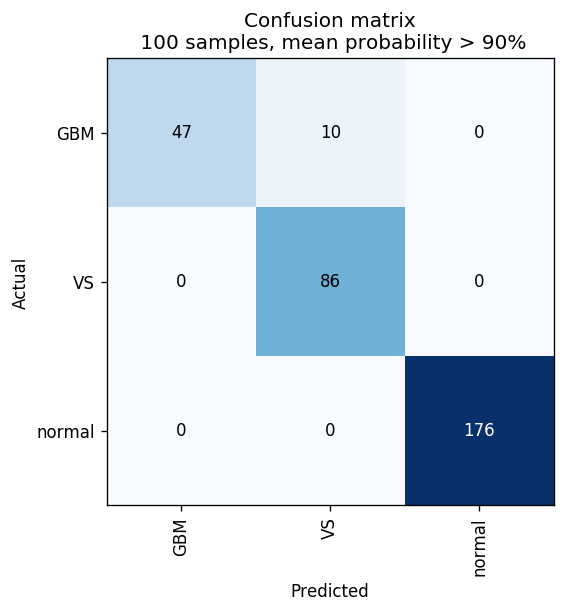

In [0]:
plot_nice_confusion_mtx(cmtx)